# 1. Library Import

In [112]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn
from sklearn.metrics import *

plt.style.use('seaborn')
sns.set(font_scale=1.5)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 2. Dataset Load

| Column Name        | Description                                                   |
|--------------------|---------------------------------------------------------------|
| ID                 | An ID representing a (Shop, Item) tuple within the test set   |
| shop_id            | Unique identifier of a shop                                   |
| item_id            | Unique identifier of a product                                |
| item_category_id   | Unique identifier of item category                            |
| item_cnt_day       | Number of products sold. You are predicting a monthly amount  |
| item_price         | Current price of an item                                      |
| date               | Date in format dd/mm/yyyy                                     |
| date_block_num     | A consecutive month number, used for convenience              |
| item_name          | Name of item                                                  |
| shop_name          | Name of shop                                                  |
| item_category_name | Name of item category                                         |

In [113]:
# data load
item_cat = pd.read_csv('./item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('./items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('./shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('./sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
test = pd.read_csv('./test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})

In [114]:
# Join data sets
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_cat, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

# 3. EDA

In [115]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [116]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [117]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [118]:
# data cleaning
train = train.loc[train['item_price'] > 0]

In [119]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


In [120]:
test.describe()

,ID,shop_id,item_id
count,214200.00,214200.00,214200.00
mean,107099.50,31.64,11019.40
std,61834.36,17.56,6252.64
min,0.00,2.00,30.00
25%,53549.75,16.00,5381.50
50%,107099.50,34.50,11203.00
75%,160649.25,47.00,16071.50
max,214199.00,59.00,22167.00


In [121]:
# data leakages
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

# test data set에 존재하는 shop_id, item_id로 재구성
lk_train = train[train['shop_id'].isin(test_shop_ids)]
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [122]:
# 전후 비교
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935848
Data set size after leaking: 1224439


In [123]:
train_monthly = lk_train.copy()
lk_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства


In [124]:
# date로 groupby
train_monthly = train_monthly.sort_values('date').groupby(
    ['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)

In [125]:
# aggregate features
train_monthly = train_monthly.agg(
    {'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean', 'count']})

In [126]:
train_monthly

date_block_num shop_id item_category_id item_id item_price          \
                                                              sum    mean   
0                   0       2                2    5572   10730.00 1532.86   
1                   0       2                2    5643    4775.21 2387.60   
2                   0       2                5    5583    1188.30  594.15   
3                   0       2                6    7893    5970.00 1990.00   
4                   0       2                6    7894    1490.00 1490.00   
...               ...     ...              ...     ...        ...     ...   
600154             33      59               75    5383    4390.00 4390.00   
600155             33      59               79   17717    8025.50  802.55   
600156             33      59               83   22087     357.00  119.00   
600157             33      59               83   22088     238.00  119.00   
600158             33      59               83   22091     179.00  179.00   

       item_cnt_day             
                sum mean count  
0                 9 1.29     7  
1                 0 0.00     2  
2                 2 1.00     2  
3                 3 1.00     3  
4                 1 1.00     1  
...             ...  ...   ...  
600154            1 1.00     1  
600155           13 1.30    10  
600156            6 2.00     3  
600157            2 1.00     2  
600158            1 1.00     1  

[600159 rows x 9 columns]

In [127]:
# rename
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 
                         'item_id', 'item_price', 'mean_item_price', 'item_cnt', 
                         'mean_item_cnt', 'transactions']
train_monthly

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,2,2,5643,4775.21,2387.60,0,0.00,2
2,0,2,5,5583,1188.30,594.15,2,1.00,2
3,0,2,6,7893,5970.00,1990.00,3,1.00,3
4,0,2,6,7894,1490.00,1490.00,1,1.00,1
...,...,...,...,...,...,...,...,...,...
600154,33,59,75,5383,4390.00,4390.00,1,1.00,1
600155,33,59,79,17717,8025.50,802.55,13,1.30,10
600156,33,59,83,22087,357.00,119.00,6,2.00,3
600157,33,59,83,22088,238.00,119.00,2,1.00,2


In [128]:
# missing value 추가
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []

for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
            
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [129]:
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00
6734444,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00
6734445,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00
6734446,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00


In [130]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00


In [131]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,6734448.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,6734448.00,11041.89,6210.74,30.00,5385.25,11265.50,16068.25,22167.00
item_category_id,6734448.00,3.79,13.21,0.00,0.00,0.00,0.00,83.00
item_price,6734448.00,187.39,2177.44,0.00,0.00,0.00,0.00,515573.59
mean_item_price,6734448.00,81.23,534.73,0.00,0.00,0.00,0.00,42990.00
item_cnt,6734448.00,0.24,3.46,-4.00,0.00,0.00,0.00,2253.00
mean_item_cnt,6734448.00,0.10,0.61,-2.00,0.00,0.00,0.00,1000.00
transactions,6734448.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00


In [132]:
# Extract time based features
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: (x // 12) + 2013)
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12) + 1)
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,1
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,1
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,1
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,1
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,1
...,...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,2015,10
6734444,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,2015,10
6734445,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,2015,10
6734446,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,2015,10


## 월별 item 판매량

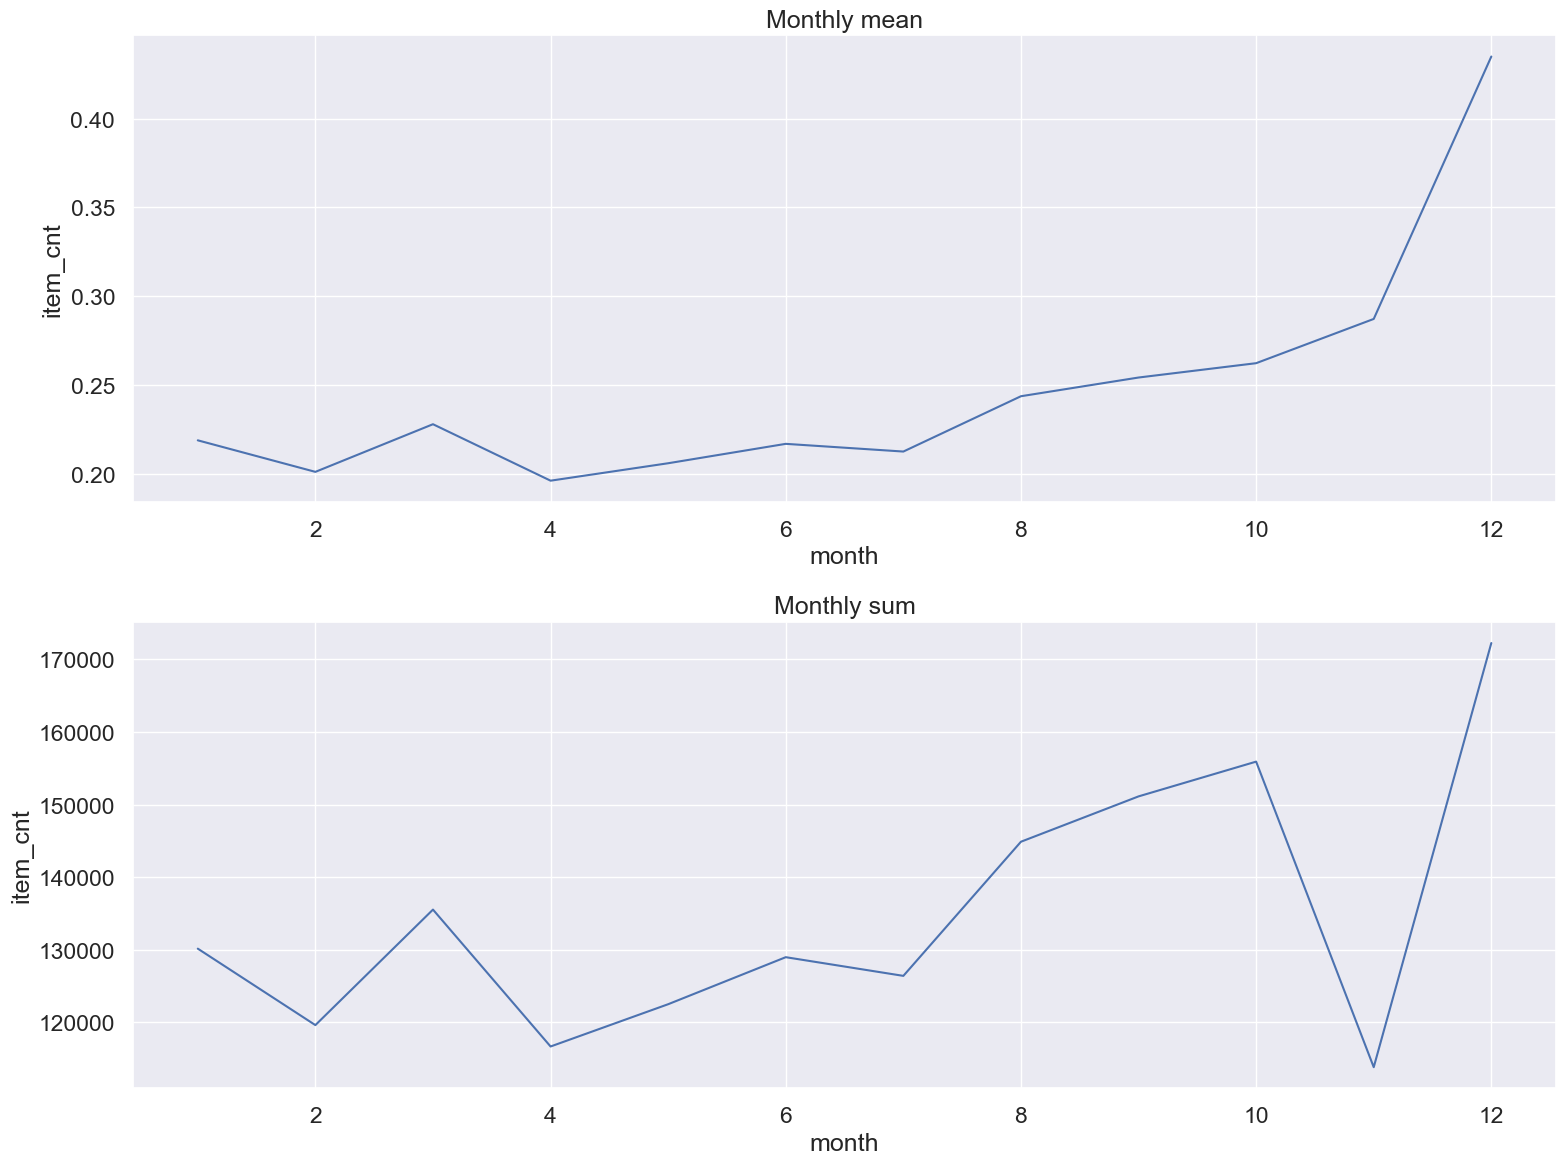

In [133]:
# 월별 item 판매량 평균
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
# 월별 item 판매량 합계
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()

# 그래프 크기 설정
plt.figure(figsize=(16,12))

# 첫 번째 subplot: 월별 item 판매량 평균
plt.subplot(2,1,1)
sns.lineplot(x='month', y='item_cnt', data=gp_month_mean)
plt.title('Monthly mean')

# 두 번째 subplot: 월별 item 판매량 합계
plt.subplot(2,1,2)
sns.lineplot(x='month', y='item_cnt', data=gp_month_sum)
plt.title('Monthly sum')

plt.tight_layout()
plt.show()

## 카테고리별 item 판매량

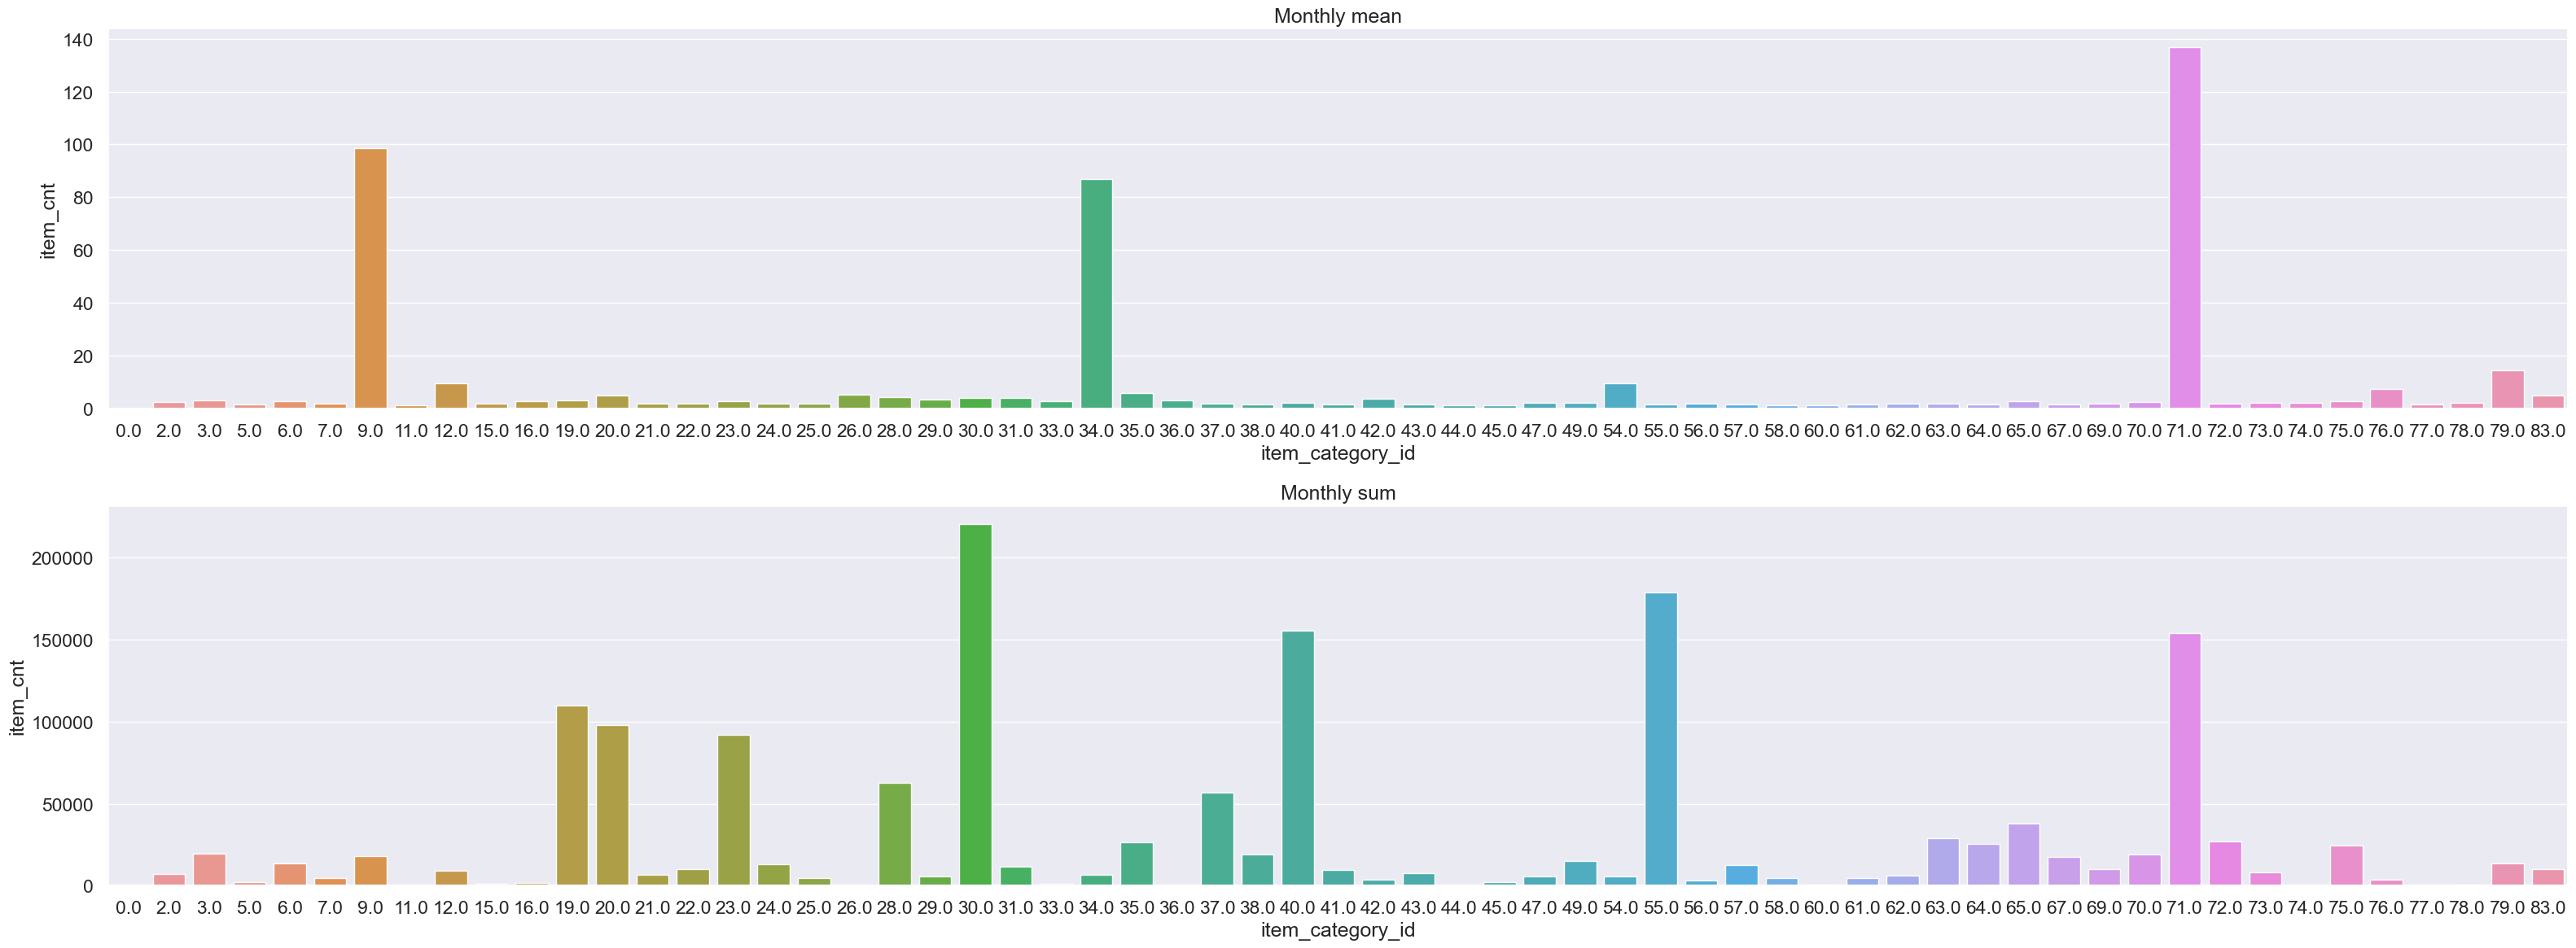

In [134]:
# 카테고리별 item 판매량 평균
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
# 카테고리별 item 판매량 합계
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()

# 그래프 크기 설정
plt.figure(figsize=(32,12))

# 첫 번째 subplot: 카테고리별 item 판매량 평균
plt.subplot(2, 1, 1)
sns.barplot(x='item_category_id', y='item_cnt', data=gp_category_mean)
plt.title('Monthly mean')

# 두 번째 subplot: 카테고리별 item 판매량 합계
plt.subplot(2, 1, 2)
sns.barplot(x='item_category_id', y='item_cnt', data=gp_category_sum)
plt.title('Monthly sum')

plt.tight_layout()
plt.show()

## 가게별 item 판매량

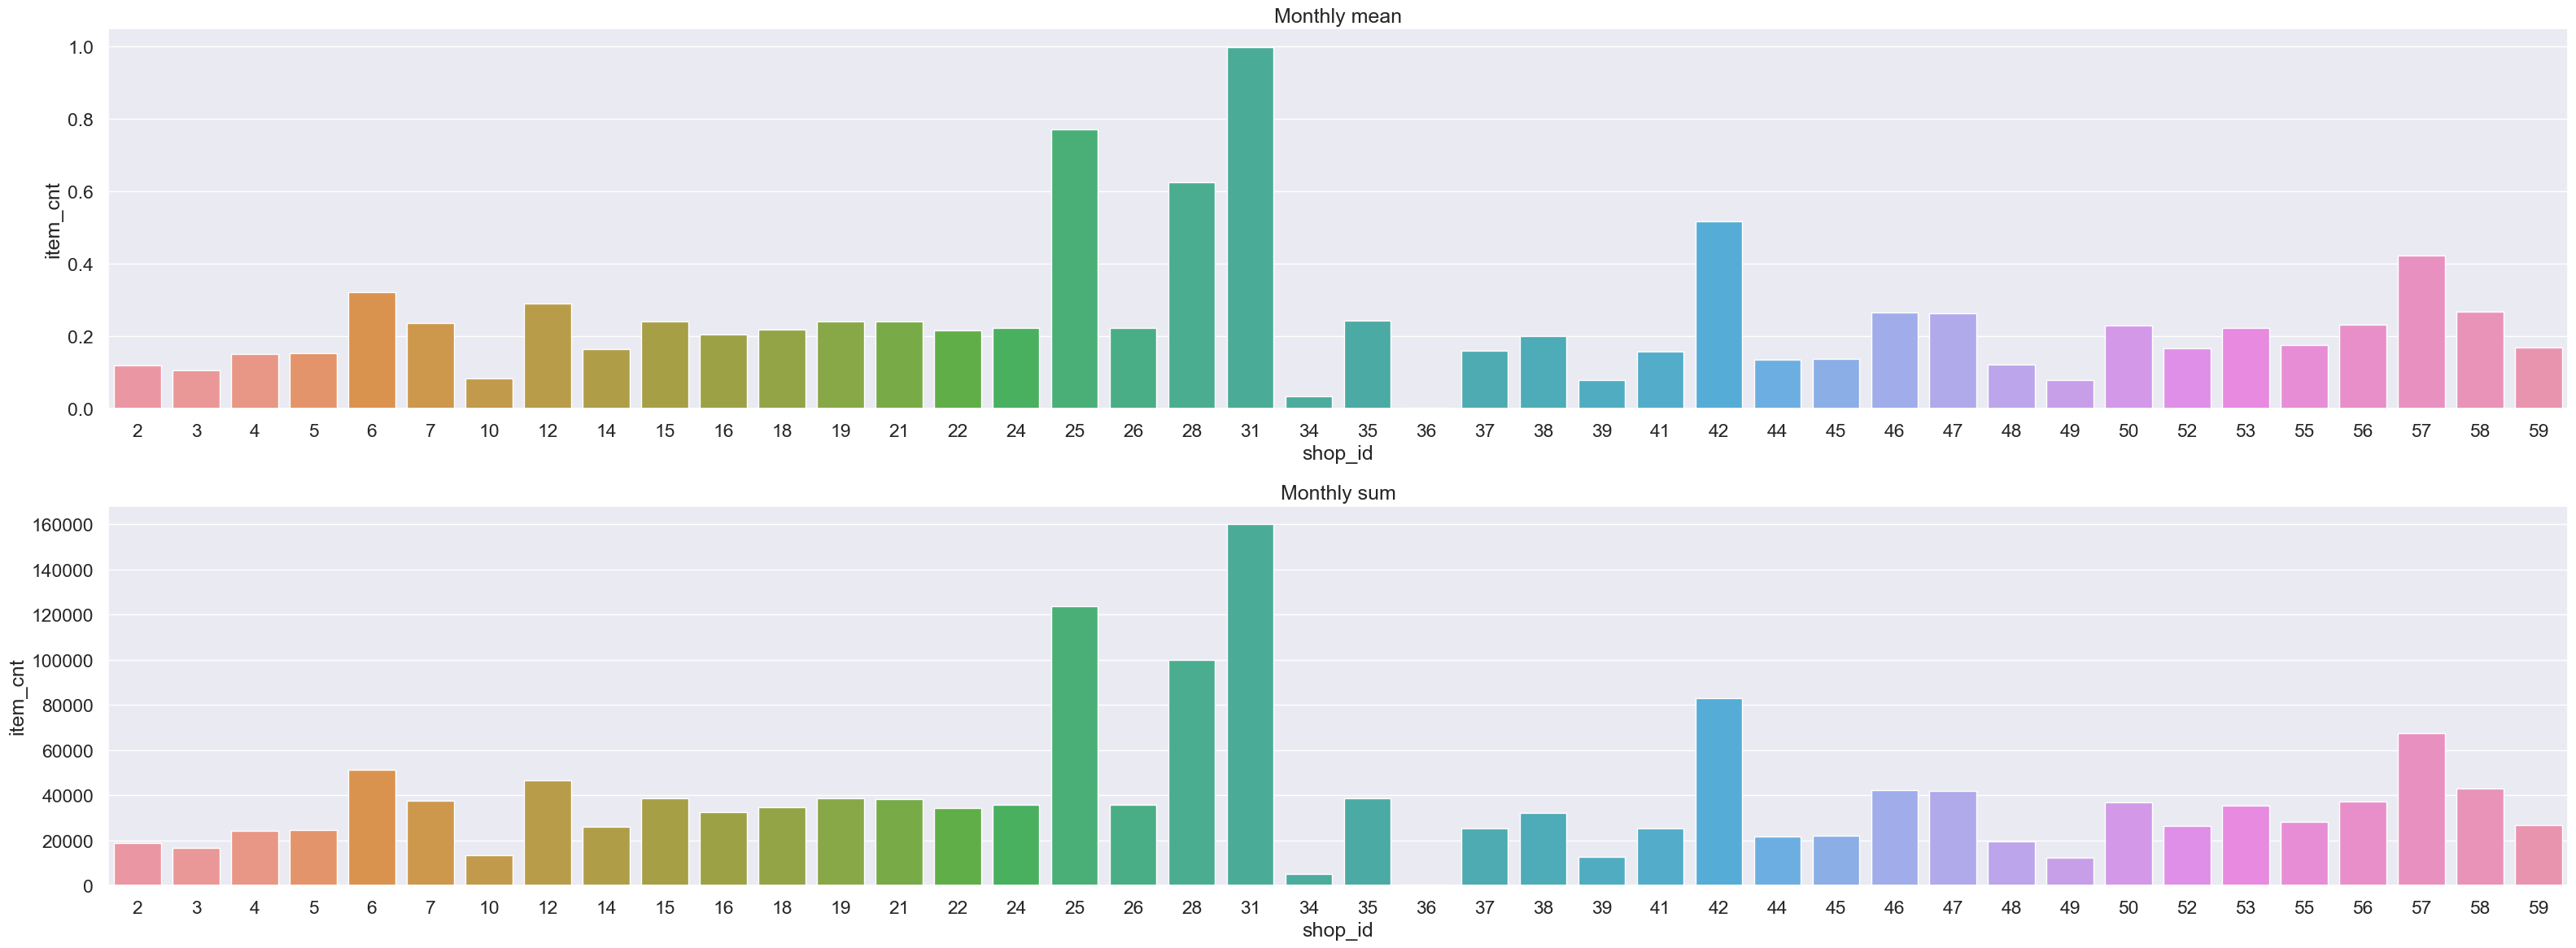

In [135]:
# 가게별 item 판매량 평균
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
# 가게별 item 판매량 합계
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

# 첫 번째 subplot: 가게별 item 판매량 평균
plt.figure(figsize=(32,12))
plt.subplot(2, 1, 1)
sns.barplot(x='shop_id', y='item_cnt', data=gp_shop_mean)
plt.title('Monthly mean')

# 두 번째 subplot: 가게별 item 판매량 합계
plt.subplot(2, 1, 2)
sns.barplot(x='shop_id', y='item_cnt', data=gp_shop_sum)
plt.title('Monthly sum')

plt.tight_layout()
plt.show()

## 이상치 처리

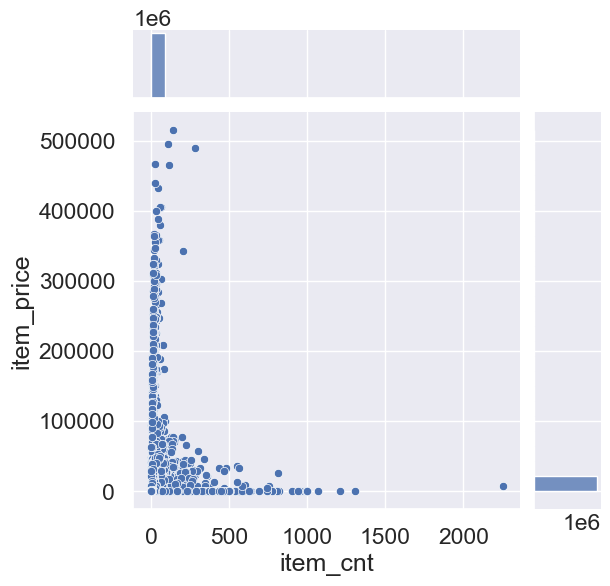

In [136]:
# jointplot을 사용하여 두 변수 간의 관계 시각화
sns.jointplot(x='item_cnt', y='item_price', data=train_monthly, kind='scatter')
plt.show()

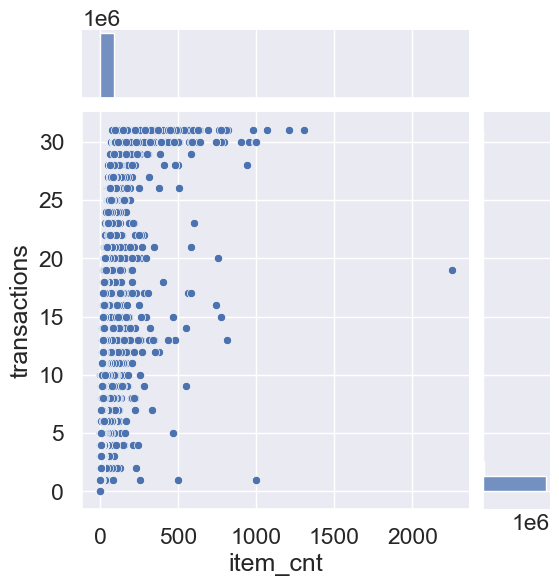

In [137]:
# jointplot을 사용하여 두 변수 간의 관계 시각화
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly)
plt.show()

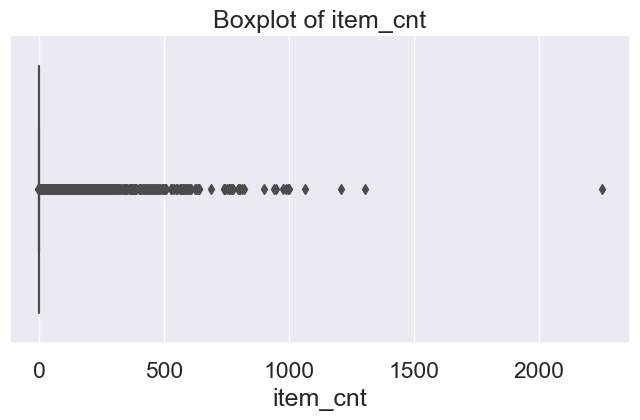

In [138]:
# item_cnt 분포보기
plt.figure(figsize=(8, 4))
sns.boxplot(x='item_cnt', data=train_monthly, orient='h')
plt.title('Boxplot of item_cnt')
plt.show()

In [139]:
# 이상치 제외
train_monthly = train_monthly.loc[train_monthly['item_cnt'] >= 0]
train_monthly = train_monthly.loc[(train_monthly['item_cnt'] <= 20) & (train_monthly['item_price'] < 400000)]

In [140]:
# 예측을 위해 다음 달의 item_cnt로 shift하여 레이블 생성
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [141]:
# item별 가격
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

In [142]:
# 가격 변동 확인을 위해 min,max값 구하기
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']
gp_item_price

,item_id,hist_min_item_price,hist_max_item_price
0,30,0.00,4389.00
1,31,0.00,9786.00
2,32,0.00,5235.00
3,33,0.00,2994.00
4,38,0.00,4798.00
...,...,...,...
4711,22162,0.00,5187.00
4712,22163,0.00,1183.00
4713,22164,0.00,7490.00
4714,22166,0.00,2100.00


In [143]:
train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,1,1.00,1192.00,0.00,18979.50
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,1,0.00,inf,0.00,35260.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,1,1.00,594.00,0.00,5592.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,1,2.00,1990.00,0.00,27950.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,1,2.00,1490.00,0.00,25880.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728113,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,500.00
6728114,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,300.00
6728115,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,1750.00
6728116,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,2980.00


In [144]:
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,1,1.00,1192.00,0.00,18979.50
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,1,0.00,inf,0.00,35260.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,1,1.00,594.00,0.00,5592.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,1,2.00,1990.00,0.00,27950.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,1,2.00,1490.00,0.00,25880.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728113,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,500.00
6728114,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,300.00
6728115,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,1750.00
6728116,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,2980.00


In [145]:
# 이동 최솟값
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# 이동 최댓값
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# 이동 평균값
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# 이동 표준 편차
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [146]:
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,1,1.00,1192.00,0.00,18979.50,9.00,9.00,9.00,0.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,1,0.00,inf,0.00,35260.00,0.00,0.00,0.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,1,1.00,594.00,0.00,5592.00,2.00,2.00,2.00,0.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,1,2.00,1990.00,0.00,27950.00,3.00,3.00,3.00,0.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,1,2.00,1490.00,0.00,25880.00,1.00,1.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728113,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,500.00,0.00,0.00,0.00,0.00
6728114,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,300.00,0.00,0.00,0.00,0.00
6728115,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,1750.00,0.00,0.00,0.00,0.00
6728116,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,2015,10,NaN,0.00,0.00,2980.00,0.00,0.00,0.00,0.00


In [147]:
# 예측을 위해 shift하여 레이블 생성
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # 빈 값은 0으로 채움
    train_monthly[ft_name].fillna(0, inplace=True)

In [148]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [149]:
# 아이템 판매량을 아이템 판매 트렌드로 설정
train_monthly['item_trend'] = train_monthly['item_cnt']

# 이전 몇 달의 판매량을 빼서 트렌드 변화 계산
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

# 평균 트렌드 계산
train_monthly['item_trend'] /= len(lag_list) + 1

In [150]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [151]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.00,16.50,9.81,0.00,8.00,16.00,25.00,33.00
shop_id,6728118.00,31.64,17.56,2.00,16.00,35.00,47.00,59.00
item_id,6728118.00,11042.87,6209.70,30.00,5386.00,11266.00,16068.00,22167.00
item_category_id,6728118.00,3.75,13.16,0.00,0.00,0.00,0.00,83.00
item_price,6728118.00,169.80,1797.75,0.00,0.00,0.00,0.00,366860.00
mean_item_price,6728118.00,79.82,525.62,0.00,0.00,0.00,0.00,42990.00
item_cnt,6728118.00,0.19,0.91,0.00,0.00,0.00,0.00,20.00
mean_item_cnt,6728118.00,0.09,0.31,0.00,0.00,0.00,0.00,20.00
transactions,6728118.00,0.17,0.74,0.00,0.00,0.00,0.00,19.00
year,6728118.00,2013.94,0.80,2013.00,2013.00,2014.00,2015.00,2015.00


# 4. Modeling

## Train/Validation split

In [152]:
# train/validation split
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

In [153]:
train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

In [154]:
print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 4946785
Validation set records: 989412
Test set records: 197879
Train set records: 4946785 (74% of complete data)
Validation set records: 989412 (15% of complete data)


## Encoding

In [155]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

In [156]:
# Add mean encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add mean encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [157]:
train_set.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,3,2,5572,2.00,2980.00,1490.00,2.00,1.00,2.00,2013,...,0.58,1.00,1.00,9.00,-2.25,0.10,1.00,0.84,0.14,0.16
1,3,2,5643,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,0.00,0.00,0.10,1.82,1.84,0.14,0.16
2,3,2,5583,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,0.00,0.00,0.10,0.59,0.04,0.14,0.16
3,3,2,7893,6.00,9350.00,1870.00,5.00,1.00,5.00,2013,...,2.08,1.00,2.00,3.00,-0.25,0.10,3.04,3.12,0.14,0.16
4,3,2,7894,0.00,0.00,0.00,0.00,0.00,0.00,2013,...,0.00,0.00,0.00,0.00,0.00,0.10,3.67,1.68,0.14,0.16


In [158]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [159]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

## Build Test set
block 33으로 block 34 예측

In [160]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

## Replace missing value

In [161]:
# 결측치 확인
print("Before filling:")
print("X_train missing values:\n", X_train.isnull().sum())
print("X_validation missing values:\n", X_validation.isnull().sum())
print("X_test missing values:\n", X_test.isnull().sum())

sets = [X_train, X_validation, X_test]

# 결측치 대체
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median

# 테스트 셋의 남아있는 결측치 대체
X_test.fillna(X_test.mean(), inplace=True)

# 결측치 확인
print("After filling:")
print("X_train missing values:\n", X_train.isnull().sum())
print("X_validation missing values:\n", X_validation.isnull().sum())
print("X_test missing values:\n", X_test.isnull().sum())

Before filling:
X_train missing values:
 shop_id                0
item_id                0
item_category_id       0
item_price             0
mean_item_price        0
item_cnt               0
mean_item_cnt          0
transactions           0
year                   0
month                  0
item_price_unit        0
hist_min_item_price    0
hist_max_item_price    0
item_cnt_min           0
item_cnt_max           0
item_cnt_mean          0
item_cnt_std           0
item_cnt_shifted1      0
item_cnt_shifted2      0
item_cnt_shifted3      0
item_trend             0
shop_mean              0
item_mean              0
shop_item_mean         0
year_mean              0
month_mean             0
dtype: int64
X_validation missing values:
 shop_id                0
item_id                0
item_category_id       0
item_price             0
mean_item_price        0
item_cnt               0
mean_item_cnt          0
transactions           0
year                   0
month                  0
item_price_unit 

In [162]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [163]:
X_test.head().T

,0,1,2,3,4
shop_id,5.00,5.00,5.00,5.00,5.00
item_id,5037.00,5320.00,5233.00,5232.00,5268.00
item_price,749.50,0.00,2997.00,0.00,0.00
mean_item_price,749.50,0.00,999.00,0.00,0.00
item_cnt,1.00,0.00,3.00,0.00,0.00
mean_item_cnt,1.00,0.00,1.00,0.00,0.00
transactions,1.00,0.00,3.00,0.00,0.00
year,2015.00,2015.00,2015.00,2015.00,2015.00
month,9.00,9.00,9.00,9.00,9.00
item_price_unit,749.00,0.00,999.00,0.00,0.00


In [164]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,214200.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,214200.00,11019.40,6252.64,30.00,5381.50,11203.00,16071.50,22167.00
item_price,214200.00,239.96,1852.61,0.00,0.00,0.00,0.00,166944.50
mean_item_price,214200.00,133.81,865.99,0.00,0.00,0.00,0.00,32990.00
item_cnt,214200.00,0.23,0.95,0.00,0.00,0.00,0.00,20.00
mean_item_cnt,214200.00,0.13,0.37,0.00,0.00,0.00,0.00,10.00
transactions,214200.00,0.20,0.73,0.00,0.00,0.00,0.00,15.00
year,214200.00,2015.00,0.00,2015.00,2015.00,2015.00,2015.00,2015.00
month,214200.00,9.00,0.00,9.00,9.00,9.00,9.00,9.00
item_price_unit,214200.00,inf,NaN,0.00,0.00,0.00,0.00,inf


## Tree based models

### catboost

In [165]:
import catboost
from catboost import Pool
from catboost import CatBoostRegressor

In [166]:
# 범주형 feature 지정
cat_features = [0, 1, 7, 8]

# 범주형 feature를 문자열로 변환
for feature in cat_features:
    X_train.iloc[:, feature] = X_train.iloc[:, feature].astype(str)
    X_validation.iloc[:, feature] = X_validation.iloc[:, feature].astype(str)

# catboost regressor 모델 초기화
catboost_model = CatBoostRegressor(
    iterations=500,              # 최대 500번 반복
    max_ctr_complexity=4,        # 최대 복잡도 설정
    random_seed=0,
    od_type='Iter',              # 과적합 조기 중단 'Iter' 설정
    od_wait=25,                  # iter 반복 횟수 25
    verbose=50,                  # 50번마다 진행 상활 출력 
    depth=4                      # 트리 깊이 설정
)

# 모델 학습
catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,            # 범주형 feature 지정
    eval_set=(X_validation, Y_validation) # validation set 지정하여 모델 성능 평가
)

Learning rate set to 0.295483
0:	learn: 0.8328357	test: 0.8758278	best: 0.8758278 (0)	total: 2.53s	remaining: 21m 3s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.8113147633
bestIteration = 10

Shrink model to first 11 iterations.


In [167]:
print('Model params:', catboost_model.get_params())

Model params: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 50, 'max_ctr_complexity': 4}


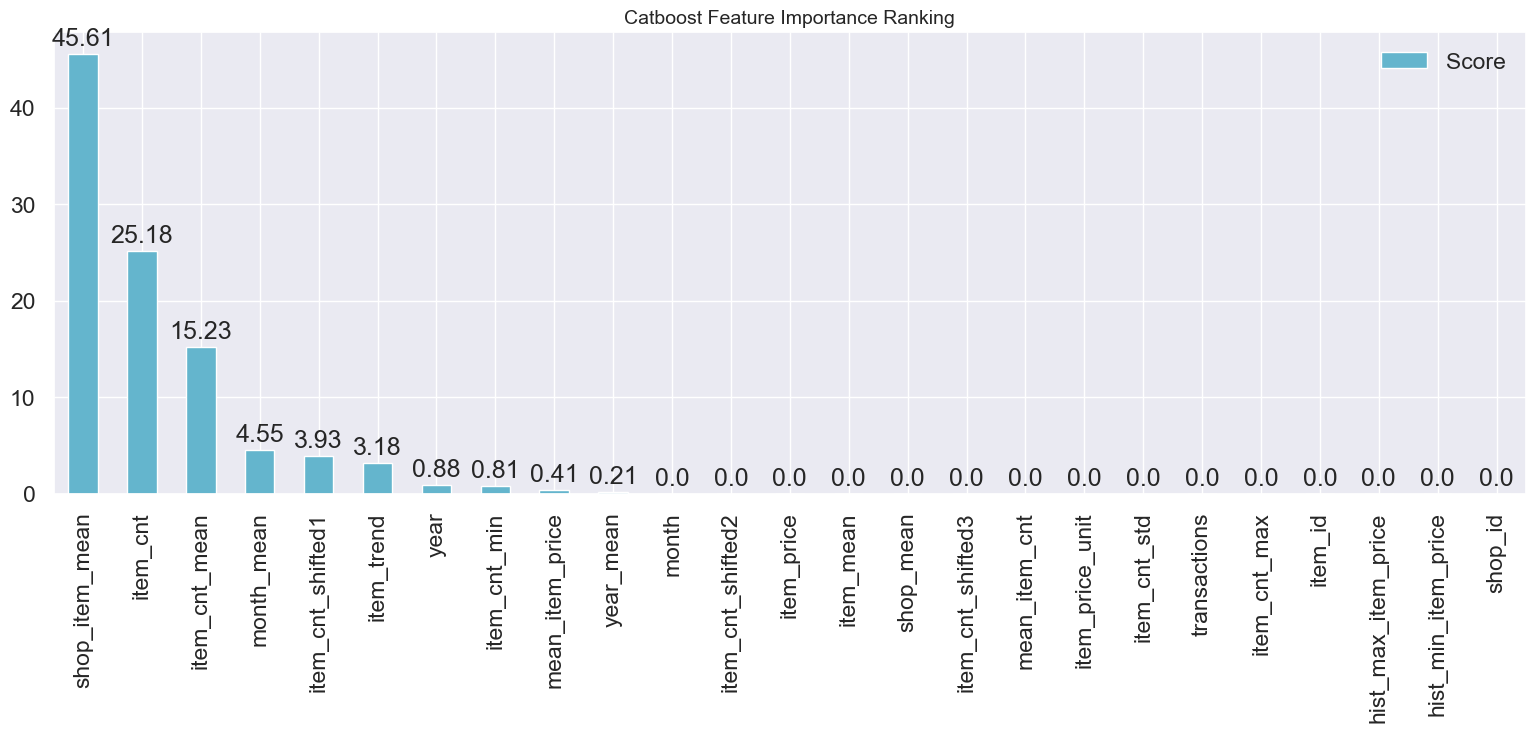

In [168]:
# feature 중요도 df 생성
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, # 피처 이름과 중요도 점수  zip
                                      catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), # 학습 데이터를 Pool 객체로 변환 후 피처 중요도 점수 계산
                             columns=['Feature','Score'])   # column명 지정

# feature_score df 정렬 (quicksort 알고리즘 / 결측치는 마지막)
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

# barplot으로 feature 중요도 그래프 그리기
plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

# 그래프의 막대 객체 목록 가져오기
rects = ax.patches
# feature 중요도를 소수점 둘째 자리까지 반올림하여 라벨 목록 생성
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    # height: 막대의 높이
    height = rect.get_height()
    # 막대 중심 x 좌표 계산, y좌표는 막대 높이 +0.35로 수평 중심 정렬, 수직 아래 정렬로 라벨 표기
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [169]:
# 모델 예측
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [170]:
# Root Mean Squared Error 계산 / 출력
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

Train rmse: 0.6750647370381281
Validation rmse: 0.8113147633159425


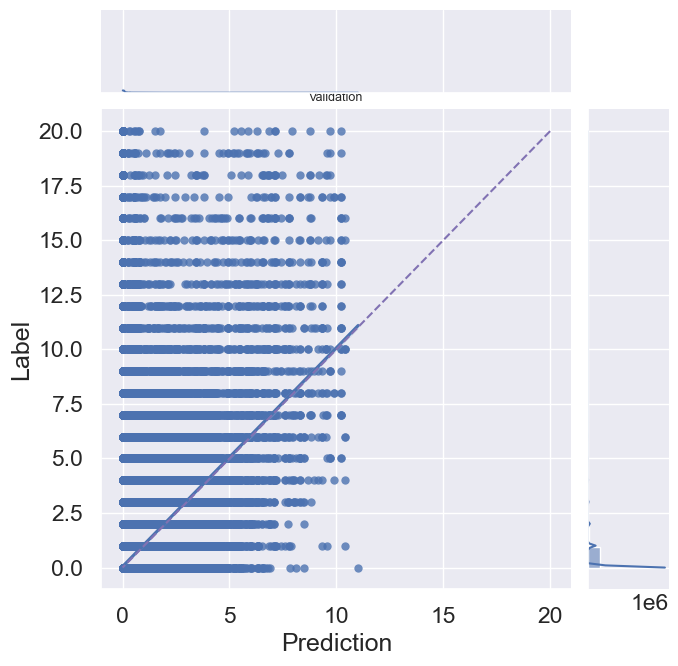

In [171]:
def model_performance_sc_plot(predictions, labels, title):
    # 실제값과 예측값의 최댓값, 최솟값으로 시각화 범위 설정
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    
    # 실제값과 예측값으로 df 생성
    performance_df = pd.DataFrame({"Label": labels})
    performance_df["Prediction"] = predictions
    
    # jointplot으로 실제값과 예측값의 상관관계 시각화 + 회귀선 추가
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    
    # 실제값과 예측값이 일치하는 선 그리기
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    
    plt.title(title, fontsize=9)
    plt.show()

model_performance_sc_plot(catboost_val_pred, Y_validation, 'Validation')

### XGBoost

In [172]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [173]:
# xgb에 사용할 feature 정의
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']

# feature 선택
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [174]:
# XGBoost 회귀 모델 초기화
xgb_model = XGBRegressor(
    max_depth=8,               # 트리의 최대 깊이 설정
    n_estimators=500,          # 생성할 트리의 수
    min_child_weight=1000,     # 최소 자식 노드 가중치 합
    colsample_bytree=0.7,      # 트리 생성 시 각 트리마다 사용할 피처의 비율
    subsample=0.7,             # 각 트리 생성 시 사용할 데이터 샘플링 비율
    eta=0.3,                   # 학습률
    seed=0                     # 랜덤 시드 설정
)

# 모델 학습
xgb_model.fit(
    xgb_train,                 # 학습 데이터
    Y_train,                   # 학습 라벨
    eval_metric="rmse",        # 평가 지표 (root mean squared error)
    eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)],  # 평가 데이터 셋
    verbose=20,                # 20 에포크마다 진행 상황 출력
    early_stopping_rounds=20   # 20 에포크 동안 성능 향상이 없으면 학습 중지
)

D:\Anaconda3\envs\self1\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
D:\Anaconda3\envs\self1\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-rmse:0.84261	validation_1-rmse:0.88835
[20]	validation_0-rmse:0.67114	validation_1-rmse:0.83055
[27]	validation_0-rmse:0.67069	validation_1-rmse:0.83300


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1000,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

<Figure size 1500x600 with 0 Axes>

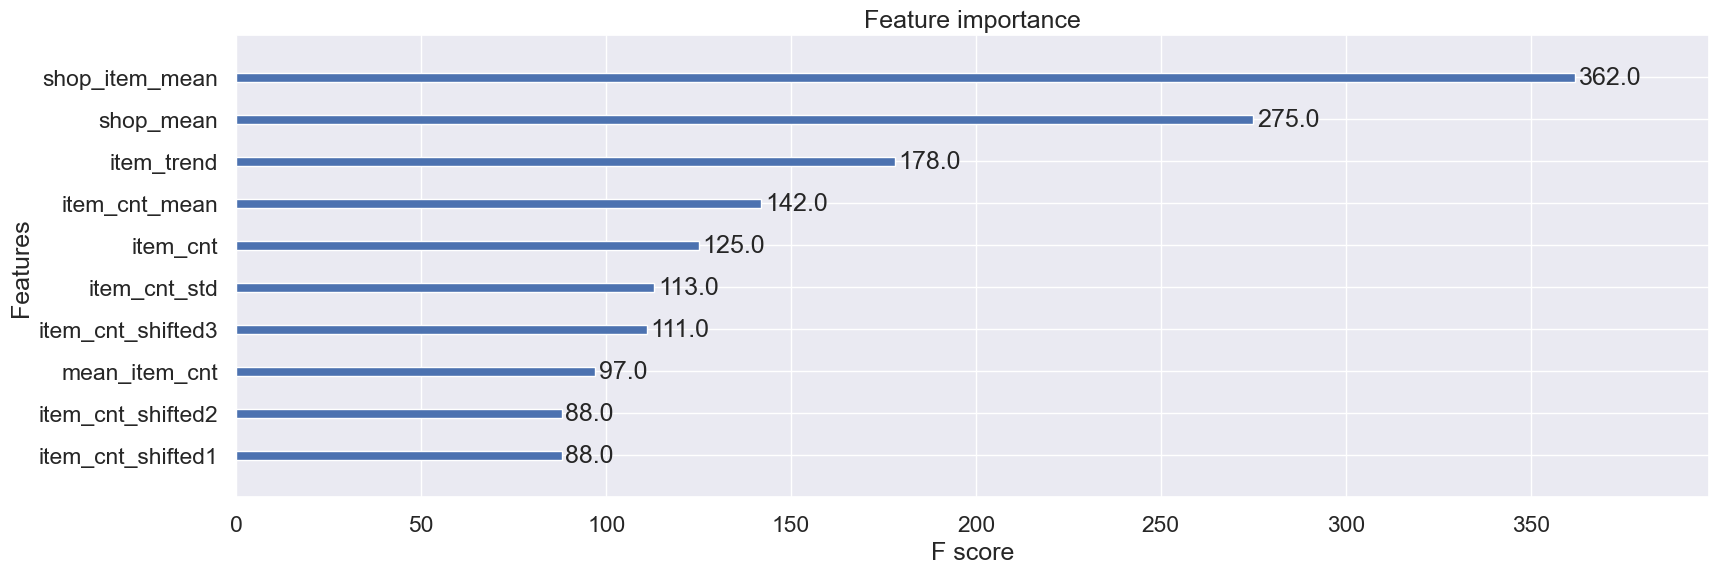

In [175]:
# xgb model의 feature 중요도 시각화
plt.figure(figsize=(15,6))
plot_importance(xgb_model)
plt.show()

In [176]:
# 학습한 모델로 예측
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [177]:
# Root Mean Squared Error 계산 / 출력
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 0.6793691137842134
Validation rmse: 0.8013754033707235


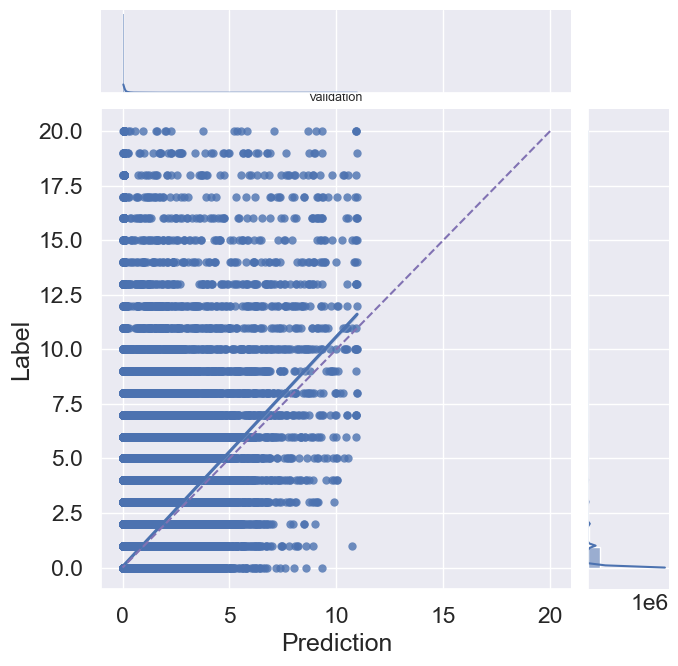

In [178]:
model_performance_sc_plot(xgb_val_pred, Y_validation, 'Validation')

### Random forest

In [179]:
from sklearn.ensemble import RandomForestRegressor

In [180]:
# random forest에 사용할 feature 정의
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']

# feature 선택
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [181]:
# random forest 모델 초기화
rf_model = RandomForestRegressor(
    n_estimators=50,       # 트리 개수 50개
    max_depth=7,           # 최대 깊이 7
    random_state=0, 
    n_jobs=-1              # 모든 CPU 사용
)

# 모델 학습
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [182]:
# 학습된 모델로 예측
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [183]:
# Root Mean Squared Error 계산 / 출력
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.6985868322226099
Validation rmse: 0.776123635046122


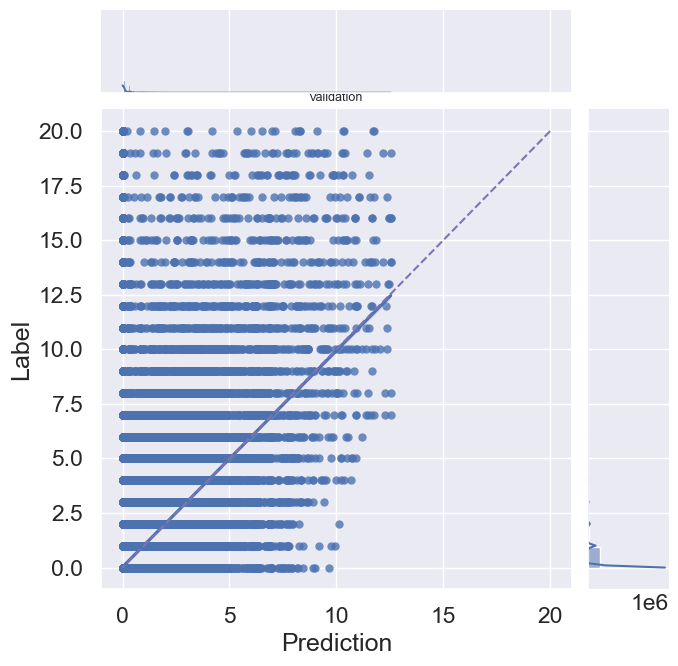

In [184]:
model_performance_sc_plot(rf_val_pred, Y_validation, 'Validation')

## Linear Regression

In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [186]:
# linear regression에 사용할 feature 정의
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']

# feature 선택
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [187]:
# MinMaxScaler 객체 생성
lr_scaler = MinMaxScaler()

# 스케일링을 위한 최소값 최대값 결정
lr_scaler.fit(lr_train)

# MinMax 스케일링 수행
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [188]:
# linear regression 모델 초기화 및 학습
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(n_jobs=-1)

In [189]:
# 학습한 모델로 예측 
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [190]:
# Root Mean Squared Error 계산 / 출력
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.7347132326333324
Validation rmse: 0.7755311093530803


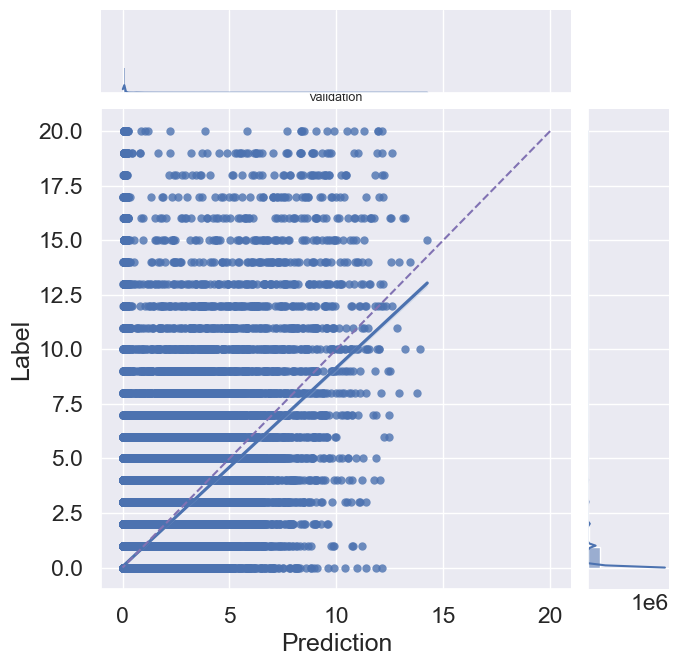

In [191]:
model_performance_sc_plot(lr_val_pred, Y_validation, 'Validation')

## KNN regressor

In [192]:
from sklearn.neighbors import KNeighborsRegressor

In [193]:
# KNN에 사용할 feature 정의
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# 소요 시간 단축을 위해 sampling해서 사용
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

# fetaure 선택
knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

In [194]:
# MinMaxScaler 객체 생성
knn_scaler = MinMaxScaler()

# 스케일링을 위한 최소값 최대값 결정
knn_scaler.fit(knn_train)

# MinMax 스케일링 수행
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [195]:
# 모델 초기화 및 학습
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(leaf_size=13, n_jobs=-1, n_neighbors=9)

In [196]:
# 학습한 모델로 예측
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [197]:
# Root Mean Squared Error 계산 / 출력
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 0.5046290655790255
Validation rmse: 0.8019220392495237


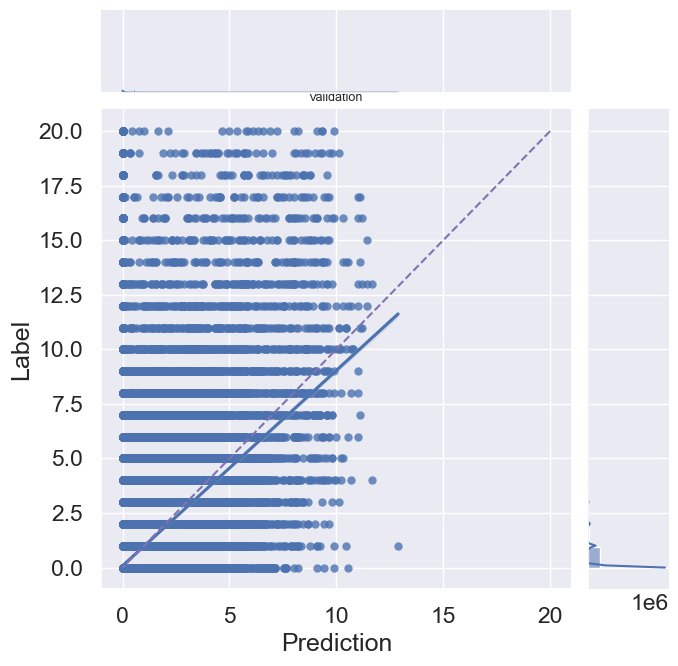

In [198]:
model_performance_sc_plot(knn_val_pred, Y_validation, 'Validation')

## stacking ensembling

In [199]:
# 각 모델별 검증 세트에 대한 예측 결과를 df로 생성
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,catboost,xgbm,random_forest,linear_regression,knn,label
0,0.82,0.70,0.62,0.60,1.00,0
1,1.02,0.73,0.56,0.04,0.78,0
2,0.03,0.07,0.21,0.04,0.11,0
3,1.22,0.92,0.95,0.04,0.11,4
4,2.01,1.64,1.57,1.46,0.67,1
5,0.94,0.69,0.46,0.04,0.11,1
6,0.59,0.46,0.21,0.04,0.11,0
7,0.03,0.07,0.06,0.04,0.11,1
8,0.46,0.38,0.21,0.04,0.11,0
9,2.04,2.27,1.13,1.15,2.89,2


In [200]:
# 각 모델별 테스트 세트에 대한 예측 결과를 df로 생성
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,xgbm,random_forest,linear_regression,knn
0,0.44,0.41,0.95,0.85,0.89
1,0.03,0.04,0.06,0.06,0.00
2,0.44,0.44,0.85,1.79,1.11
3,0.03,0.04,0.00,0.06,0.00
4,0.03,0.04,0.06,0.06,0.00


<img src='https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Predict%20Future%20Sales/Ensemble%20Kaggle.jpg'>

In [201]:
meta_model = LinearRegression(n_jobs=-1)

In [202]:
# validation set 제외
first_level.drop('label', axis=1, inplace=True)
# 각 모델의 예측 결과를 feature로 앙상블 학습
meta_model.fit(first_level, Y_validation)

LinearRegression(n_jobs=-1)

In [203]:
# 학습한 모델로 예측
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [204]:
# Root Mean Squared Error 계산 / 출력
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 0.7650023117961924


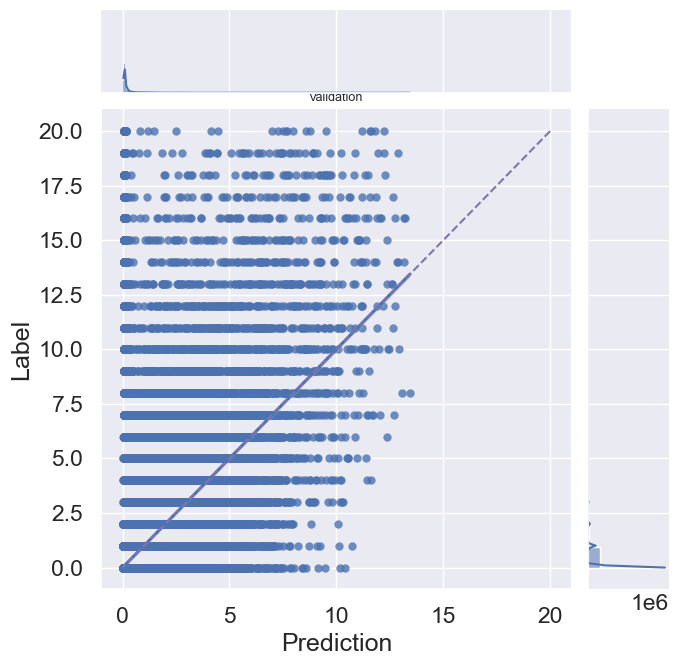

In [205]:
model_performance_sc_plot(ensemble_pred, Y_validation, 'Validation')

In [206]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.85
1,1,0.08
2,2,1.28
3,3,0.06
4,4,0.08
5,5,0.93
6,6,1.20
7,7,0.21
8,8,1.98
9,9,0.06
